# QA/QC of eye-tracking data

This notebook visualizes ET data for the purpose of QC'ing BIDS conversion and the data themselves.

In [1]:
%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et
from matplotlib import pyplot as plt
import plot

from IPython.display import HTML
from matplotlib import animation
import matplotlib.image as mpimg

In the schedule.tsv file, we've listed the EDF files we created and their associated sessions. Now, let's check out what's in the file.

As an illustrative example, we'll handle the data from session 4. Replace `DATA_PATH` with your data's path.

In [2]:
BIDS_PATH = Path("/data/datasets/hcph")
session = "004"

## Eye-tracking during the diffusion weighted imaging (DWI) run

Let's begin opening the eye-tracking information collected during a DWI run.
It's stored with BIDS conventions, so data is found in a "headless" `tsv.gz` file.

In [3]:
recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())

recording = pd.read_csv(
    recording_file,
    sep=r"\s+",
    header=None,
    index_col=None,
    na_values="n/a",
    names=metadata["Columns"],
)

### Metadata and calibration

The DWI run of our protocol is the first time the eye-tracker is employed.
Therefore, we always run a calibration before it is started.
As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [4]:
print(
    json.dumps(metadata, sort_keys=True, indent=2, cls=ppjson.CompactJSONEncoder)
)

{
  "AverageCalibrationError": 0.49,
  "CalibrationCount": 1,
  "CalibrationLog": [
    [9898190, ">>>>>>> CALIBRATION (HV9,P-CR) FOR RIGHT: <<<<<<<<<"],
    [9898190, "Calibration points:"],
    [9898190, "-18.8, -42.0         0,      0"],
    [9898190, "-16.8, -58.4         0,  -2457"],
    [9898190, "-20.0, -25.9         0,   2457"],
    [9898190, "-45.1, -42.6     -3474,      0"],
    [9898190, "10.2, -40.9      3474,      0"],
    [9898190, "-45.4, -59.0     -3474,  -2457"],
    [9898190, "11.1, -55.5      3474,  -2457"],
    [9898190, "-47.5, -27.1     -3474,   2457"],
    [9898190, "8.6, -25.6      3474,   2457"],
    [9898190, "eye check box: (L,R,T,B)\n\t  -53    17   -62   -22"],
    [9898190, "href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686"],
    [
      9898190,
      "Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  125.7  12.521 -0.22744 -0.18622 \n   4.4115e-05 -4.6332  150.8 -0.048749  0.093667"
    ],
    [9898190, "Prenormalize: offx, offy = -18

In [5]:
recording

,x_coordinate,y_coordinate,pupil_size,pupil_x_coordinate,pupil_y_coordinate,fixation,saccade,blink,href_x_coordinate,href_y_coordinate,fast_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp
0,453.399994,126.699997,6090.0,-1675.0,-6632.0,0,0,0,527.0,-1709.0,0.0,26.700001,26.799999,9941595
1,453.500000,127.800003,6101.0,-1676.0,-6622.0,0,0,0,528.0,-1698.0,0.0,26.700001,26.799999,9941596
2,453.799988,129.000000,6092.0,-1674.0,-6613.0,0,0,0,531.0,-1687.0,0.0,26.700001,26.799999,9941597
3,454.000000,129.500000,6083.0,-1672.0,-6609.0,0,0,0,533.0,-1682.0,0.0,26.700001,26.799999,9941598
4,454.200012,128.399994,6081.0,-1670.0,-6617.0,0,0,0,534.0,-1692.0,0.0,26.700001,26.799999,9941599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831430,NaN,NaN,NaN,-32768.0,-32768.0,0,1,1,-7936.0,-7936.0,NaN,30.799999,32.599998,11773025
1831431,NaN,NaN,NaN,-32768.0,-32768.0,0,1,1,-7936.0,-7936.0,NaN,30.799999,32.599998,11773026
1831432,NaN,NaN,NaN,-32768.0,-32768.0,0,1,1,-7936.0,-7936.0,NaN,30.799999,32.599998,11773027
1831433,NaN,NaN,NaN,-32768.0,-32768.0,0,1,1,-7936.0,-7936.0,NaN,30.799999,32.599998,11773028


Let's look into the gaze coordinates only:

In [6]:
data = recording[["x_coordinate", "y_coordinate"]]

data[data.x_coordinate.notna() & data.y_coordinate.notna()]

,x_coordinate,y_coordinate
0,453.399994,126.699997
1,453.500000,127.800003
2,453.799988,129.000000
3,454.000000,129.500000
4,454.200012,128.399994
...,...,...
1785114,805.299988,1006.299988
1785115,804.799988,990.500000
1785116,806.299988,986.200012
1785117,807.099976,985.400024


### Plotting some data

Let's first generate a time axis `t_axis` in seconds.
To do so, we read the "timestamp" column of the dataframe, and divide by the sampling frequency (stored within the metadata).
In order to make it more "BIDS-y", we also set the start of the run at zero by applying the start time metadata.

In [7]:
t_axis = (
    recording.timestamp.values - metadata["StartTimestamp"]
) / metadata["SamplingFrequency"]

Once we have the sampling axis, we can look at a basic measurement: pupil area in arbitrary units (as it comes from the EyeLink tracker).
With our conversion into BIDS, pupil area (column `pa_right` of the EDF file) is mapped to the `eye1_pupil_size` column of the `_eyetrack.tsv.gz` file.
We first create a figure with landscape ratio to better get a sense of the data along time.

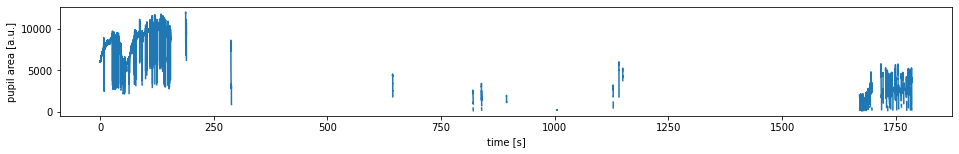

In [8]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

We can zoom in into the early moments of the run:

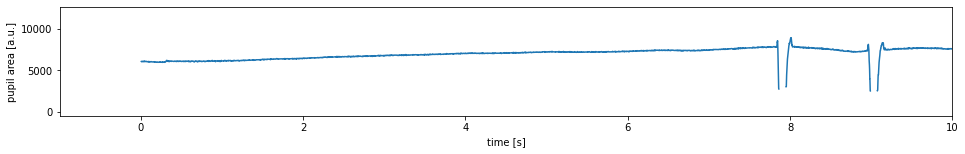

In [9]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((-1.0, 10.0));

Next, we look at eye blinks.
The two discontinuities at almost seconds 8 and 9 of the pupil area plot could be related to blinks.

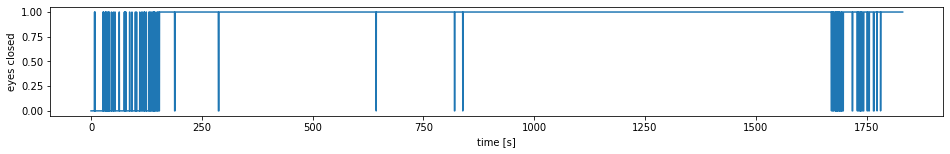

In [10]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

Looks like the eyes (or at least the right eye, which was tracked) were closed during most of the run.
Let's now plot together the first ten seconds of pupil area AND the blinks binary signal.
Indeed, the pupil area drops when blinks are happening.

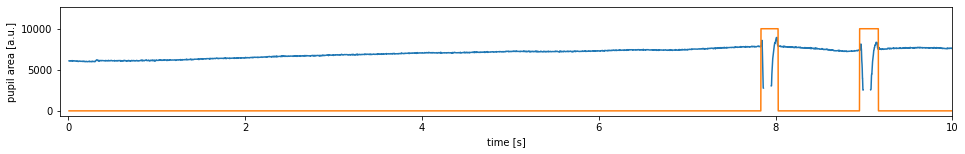

In [11]:
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.plot(
    t_axis,
    recording["blink"].values * 10000,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((-0.1, 10.0));

We can clean up the pupil area time series by removing data while the eye was closed.
The signal seems to display fewer artifacts.

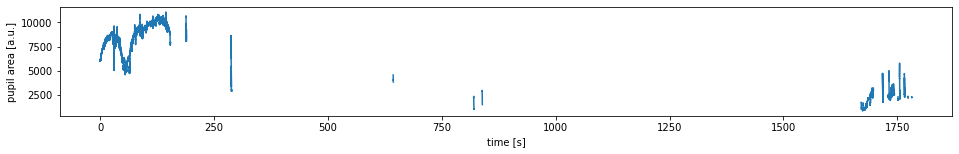

In [12]:
pupil_area = recording["pupil_size"].values
pupil_area[recording["blink"] > 0] = np.nan

fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

We can also see the map of time spent on areas of the screen.
First, we extract the screen size from the JSON metadata `_eyetrack.json`.
Second, we select the pupil gaze columns in the recordings table (corresponding to `_eyetrack.tsv.gz`).
Finally, we use our helper plotter to show the gaze frequency map:

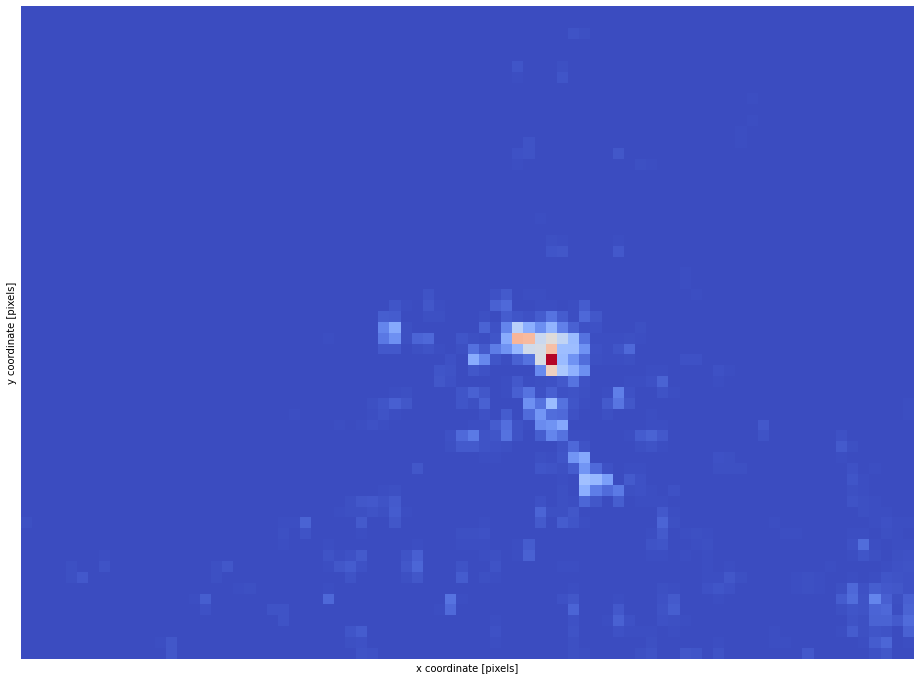

In [13]:
size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)
data = recording[["x_coordinate", "y_coordinate"]]
data = data[recording.blink < 1]
plot.plot_heatmap_coordinate(data, density=False, screen_size=size);

### Contrasting the gaze at the beginning and end of the "task"

At the start and end of the DWI run, we presented two central fixation points during 60s, serving as reference markers for the analysis of potential gaze drift (i.e., shifts in gaze coordinates). Let's compare the density maps during these two fixation points to assess the drift during the DWI.

First, we extract the data corresponding to the two fixation points:

In [14]:
fixation_duration = 60

start_first_fixation = metadata["StartTimestamp"]
stop_first_fixation = start_first_fixation + (
    fixation_duration * metadata["SamplingFrequency"]
)
stop_second_fixation = metadata["StopTimestamp"]
start_second_fixation = stop_second_fixation - (
    fixation_duration * metadata["SamplingFrequency"]
)

data_first_fixation = recording[
    (recording["timestamp"] >= start_first_fixation)
    & (recording["timestamp"] <= stop_first_fixation)
]

data_second_fixation = recording[
    (recording["timestamp"] >= start_second_fixation)
    & (recording["timestamp"] <= stop_second_fixation)
]

We can now create an animation that displays the heatmap of the coordinates during those two fixation points.

In [15]:
HEATMAP_ANIMATION_FIGURE_SIZE = (13, 13 * size[1] / size[0])

fig, ax = plt.subplots(figsize=HEATMAP_ANIMATION_FIGURE_SIZE, layout="tight")


def update(frame):
    if frame == 0:
        return plot.plot_heatmap_coordinate(
            data_first_fixation, ax=ax, density=False, screen_size=size
        )

    return plot.plot_heatmap_coordinate(
        data_second_fixation, ax=ax, density=False, screen_size=size
    )


num_frames = 2
anim = animation.FuncAnimation(
    fig, update, frames=num_frames, interval=2000, repeat=True, blit=False
);

plt.close('all');
plt.clf();
HTML(anim.to_html5_video())

<Figure size 432x288 with 0 Axes>

It's interesting to observe that the gaze during the second fixation wasn't centered on the screen, which is unexpected.
This likely happened because the participant's eye was mostly closed during the presentation of the second fixation point at the end of the run.
To verify this, let's plot the blink data for the final fixation stimulus:

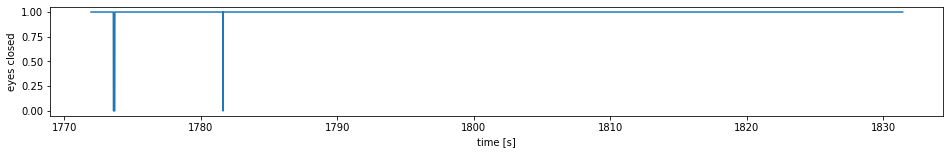

In [16]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    (data_second_fixation["timestamp"].values - metadata["StartTimestamp"])
    / metadata["SamplingFrequency"],
    data_second_fixation["blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

# Quality Control task (QCT)

Now, let's repeat the process for the QCT, which is a short task with a number of stimuli.
We'll encapsulate the session data and showcase the same visualizations.
Since we have changed of task, we open the corresponding file and generate a new *time* axis:

In [17]:
recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "func" / f"sub-001_ses-{session}_task-qct_dir-RL_recording-eyetrack_physio.tsv.gz"

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())

recording = pd.read_csv(
    recording_file,
    sep=r"\s+",
    header=None,
    index_col=None,
    na_values="n/a",
    names=metadata["Columns"],
)

t_axis = (recording.timestamp.values - metadata["StartTimestamp"]) / metadata["SamplingFrequency"]

First, let's look at the pupil size after filtering out blinks:

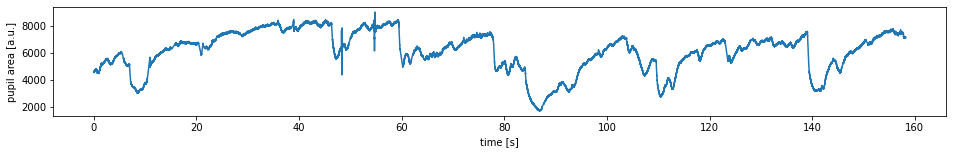

In [18]:
fig = plt.figure(figsize=(16, 2));
plt.plot(
    t_axis[recording.blink == 0],
    recording.loc[recording.blink == 0, "pupil_size"].values,
)

plt.xlabel("time [s]");
plt.ylabel("pupil area [a.u.]");

The duration of eyeblinks provides insights into the participant's wakefulness during the task. Let's visualize the eyeblink duration specifically for the QCT. Here the plot looks very different compared to the DWI run. The short blink durations in the QCT plot suggest that the participant likely kept their tracked eye open throughout the session.

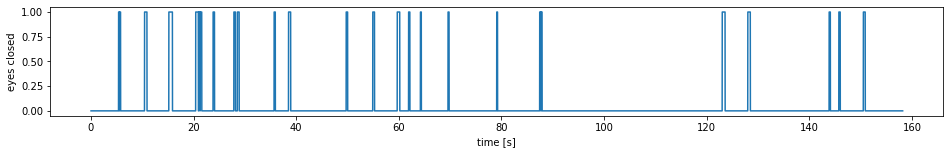

In [19]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

### Events (or "triggers") in the QCT

The QCT comprises four randomly ordered tasks: visual gratings, fingertapping with hand instructions, cognitive gaze movement, and blank trials with a central fixation point. Messages are sent by the Psychopy experiment at the beginning and end of each subtask, and these are stored in the 'LoggedMessages' field of et_qct.metadata. Let's examine these messages:

In [20]:
logged_messages = metadata['LoggedMessages']
logged_messages

[[12654533, 'NO Reply is disabled for function eyelink_cal_result'],
 [12691732, 'RECCFG CR 1000 2 0 R'],
 [12691732, 'ELCLCFG TOWER'],
 [12692244, 'start blank loop'],
 [12695241, 'stop blank loop'],
 [12695286, 'start blank loop'],
 [12698275, 'stop blank loop'],
 [12698320, 'start vis loop'],
 [12701326, 'stop vis loop'],
 [12701393, 'start mot loop'],
 [12706383, 'stop mot loop'],
 [12706394, 'start mot loop'],
 [12711390, 'stop mot loop'],
 [12711442, 'start blank loop'],
 [12714440, 'stop blank loop'],
 [12714496, 'start mot loop'],
 [12719497, 'stop mot loop'],
 [12719503, 'start mot loop'],
 [12724505, 'stop mot loop'],
 [12724562, 'start mot loop'],
 [12729562, 'stop mot loop'],
 [12729569, 'start mot loop'],
 [12734569, 'stop mot loop'],
 [12734626, 'start cog loop'],
 [12735118, 'stop cog loop'],
 [12735121, 'start cog loop'],
 [12735630, 'stop cog loop'],
 [12735634, 'start cog loop'],
 [12736128, 'stop cog loop'],
 [12736132, 'start cog loop'],
 [12736625, 'stop cog loop']

To visualize the data of each subtask separately, let's construct a dictionary.
Each entry will encapsulate a dataframe with data from one of these subtasks.

In [21]:
subtask_dataframes = {}
n_task = 0
for i in range(len(logged_messages)):
    entry = logged_messages[i]
    if "start" in entry[1]:
        start_time = entry[0]
        subtask_type = entry[1].split()[1]
        stop_time = None

        for j in range(i + 1, len(logged_messages)):

            stop_entry = logged_messages[j]
            if "stop" in stop_entry[1] and (subtask_type in stop_entry[1]):
                stop_time = stop_entry[0]
                n_task = n_task + 1
                break

        if stop_time is not None:

            subtask_data = recording[
                (recording["timestamp"] >= start_time)
                & (recording["timestamp"] <= stop_time)
            ]

            df_name = f"df_{subtask_type}_{n_task}"
            subtask_dataframes[df_name] = subtask_data


Now we can plot the heatmap of the gaze coordinates for each of the subtasks.

In [22]:
fig, ax = plt.subplots(figsize=HEATMAP_ANIMATION_FIGURE_SIZE, layout="tight");

def update(frame):
    ax.clear()
    dataframe = list(subtask_dataframes.values())[frame]

    if dataframe is not None:
        plot.plot_heatmap_coordinate(
            dataframe[["x_coordinate", "y_coordinate"]],
            ax=ax,
            density=False,
            screen_size=size,
        )

        subtask_name = (
            list(subtask_dataframes.keys())[frame].split("_")[1].capitalize()
        )
        ax.set_title(f"Subtask: {subtask_name}")


num_frames = len(subtask_dataframes)

anim = animation.FuncAnimation(
    fig, update, frames=num_frames, interval=1000, repeat=True, blit=False
);
plt.close("all");
plt.clf();

HTML(anim.to_html5_video())

<Figure size 432x288 with 0 Axes>

During cognitive (cog) events, a noticeable bimodal distribution in gaze coordinates emerges, reflecting the participant's delayed reaction to stimuli. The initial portion of the gaze distribution persists on the coordinates of the preceding stimuli, while the subsequent part aligns with the coordinates of the currently displayed stimulus.

# Resting-state fMRI run
Now, let's do the same for the resting state. We'll encapsulate the session data and show similar visualizations.


In [23]:
recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "func" / f"sub-001_ses-{session}_task-rest_dir-RL_recording-eyetrack_physio.tsv.gz"

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())

recording = pd.read_csv(
    recording_file,
    sep=r"\s+",
    header=None,
    index_col=None,
    na_values="n/a",
    names=metadata["Columns"],
)

t_axis = (recording.timestamp.values - metadata["StartTimestamp"]) / metadata["SamplingFrequency"]

Let's first have a look at the blinks duration.

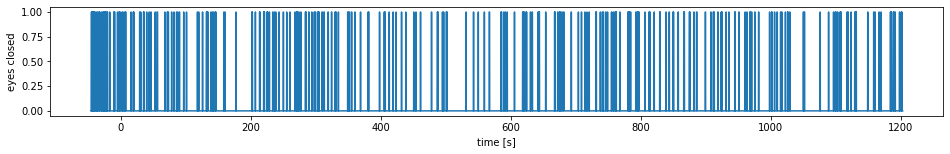

In [24]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

The resting state task comprises three events: initial and final fixation points for drift estimation and a 20-minute movie. Let's start by analyzing the data recorded during the movie. At the beginning and end of the movie, the Psychopy experiment sends the messages'start movie' and 'end movie'. The start of the movie correspond to the first trigger sent by the scanner. First, let's extract the data corresponding to the movie.

In [25]:
start_movie_timestamp = metadata["StartTimestamp"]
stop_movie_timestamp = [
    entry[0] for entry in metadata["LoggedMessages"] if "end movie" in entry[1]
][0]
data_movie = recording[
    (recording["timestamp"] >= start_movie_timestamp)
    & (recording["timestamp"] <= stop_movie_timestamp)
]

We can now plot the heatmap of the gaze coordinates during the movie.

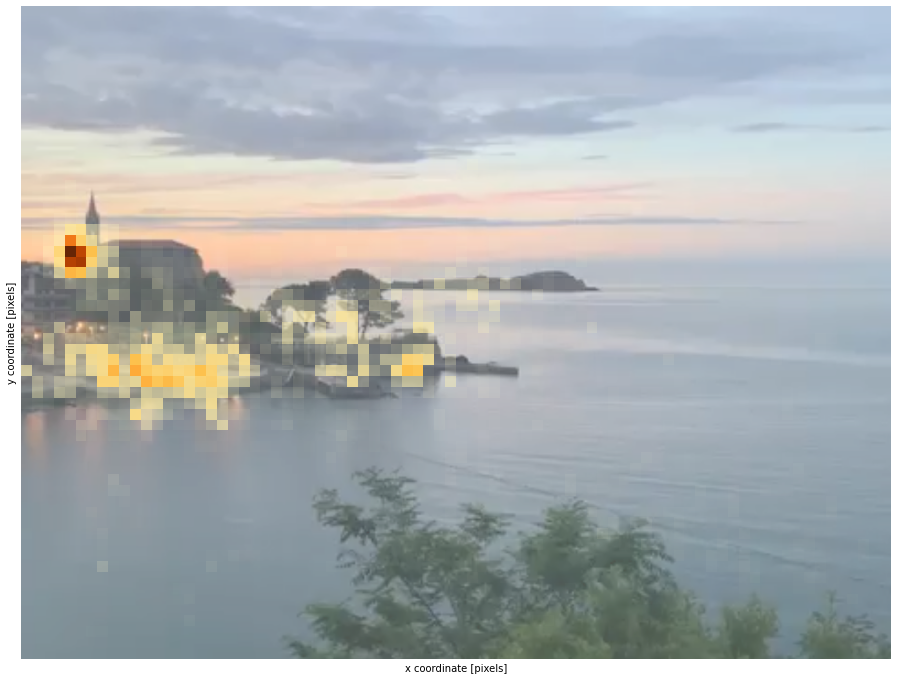

In [26]:
plot.plot_heatmap_coordinate(
    data_movie[["x_coordinate", "y_coordinate"]],
    density=False,
    screen_size=size,
    background_image="mundaka-image.png",
);

This provides a general overview of the most focal area for the gaze. Now, for a dynamic view of how the gaze moved during the movie, we can run the next cell. It will generate an animated plot illustrating the trajectory of the gaze.

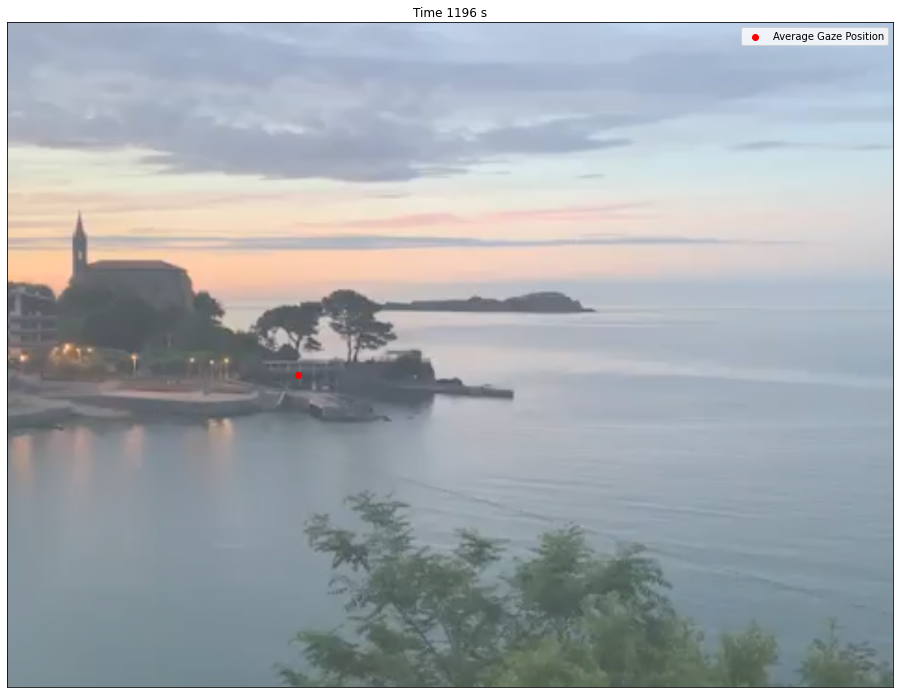

In [27]:
plt.ioff();

def update(frame, timestamps_per_frame, background_image):
    start_idx = frame * timestamps_per_frame
    end_idx = (frame + 1) * timestamps_per_frame
    if end_idx > len(data_movie):
        end_idx = len(data_movie)
    subset_data = data_movie.iloc[start_idx:end_idx]
    time = int(
        (data_movie.iloc[start_idx]["timestamp"] - metadata["StartTimestamp"])
        / metadata["SamplingFrequency"]
    )
    avg_x = subset_data["x_coordinate"].mean()
    avg_y = subset_data["y_coordinate"].mean()

    ax.clear()
    ax.scatter(avg_x, avg_y, color="red", marker="o", label="Average Gaze Position")
    ax.legend()

    extent = [
        metadata["ScreenAOIDefinition"][1][0],
        metadata["ScreenAOIDefinition"][1][1],
        metadata["ScreenAOIDefinition"][1][3],
        metadata["ScreenAOIDefinition"][1][2],
    ]
    background = mpimg.imread(background_image)
    ax.imshow(background, zorder=0, extent=extent, alpha=0.7)
    ax.set_title(f"Time {time} s")
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[3], extent[2])
    ax.invert_yaxis()
    plt.xticks([], [])
    plt.yticks([], [])


fig, ax = plt.subplots(figsize=HEATMAP_ANIMATION_FIGURE_SIZE, layout="tight")


timestamps_per_frame = 4000
background_image = "mundaka-image.png"
anim = animation.FuncAnimation(
    fig,
    update,
    frames=len(data_movie) // timestamps_per_frame,
    repeat=False,
    blit=False,
    fargs=(timestamps_per_frame, background_image),
)

HTML(anim.to_html5_video())

Now, let's use the two fixation points to get an idea of the drift during the resting state run, similar to the approach used for the DWI run.

In [28]:
start_first_fixation = [
    entry[0]
    for entry in metadata["LoggedMessages"]
    if "start fixation" in entry[1]
][0]
stop_first_fixation = [
    entry[0]
    for entry in metadata["LoggedMessages"]
    if "end fixation" in entry[1]
][0]
stop_second_fixation = [
    entry[0]
    for entry in metadata["LoggedMessages"]
    if "end fixation" in entry[1]
][1]
start_second_fixation = [
    entry[0]
    for entry in metadata["LoggedMessages"]
    if "start fixation" in entry[1]
][1]

data_first_fixation = recording[
    (recording["timestamp"] >= start_first_fixation)
    & (recording["timestamp"] <= stop_first_fixation)
]
data_second_fixation = recording[
    (recording["timestamp"] >= start_second_fixation)
    & (recording["timestamp"] <= stop_second_fixation)
]


In [29]:
fig, ax = plt.subplots(figsize=HEATMAP_ANIMATION_FIGURE_SIZE, layout="tight");


def update(frame):
    if frame == 0:
        return plot.plot_heatmap_coordinate(
            data_first_fixation, ax=ax, density=False, screen_size=size
        )
    return plot.plot_heatmap_coordinate(
        data_second_fixation, ax=ax, density=False, screen_size=size
    )


num_frames = 2
anim = animation.FuncAnimation(
    fig, update, frames=num_frames, interval=2000, repeat=False, blit=False
);
plt.close("all");
plt.clf();

HTML(anim.to_html5_video())

<Figure size 432x288 with 0 Axes>

# Breath-holding task (BHT)
Lastly, let's explore the breath-holding task data. To start, we'll look at the changes in pupil size throughout the task.

In [30]:
recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "func" / f"sub-001_ses-{session}_task-bht_dir-RL_recording-eyetrack_physio.tsv.gz"

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())

recording = pd.read_csv(
    recording_file,
    sep=r"\s+",
    header=None,
    index_col=None,
    na_values="n/a",
    names=metadata["Columns"],
)

t_axis = (recording.timestamp.values - metadata["StartTimestamp"]) / metadata["SamplingFrequency"]

<Figure size 432x288 with 0 Axes>

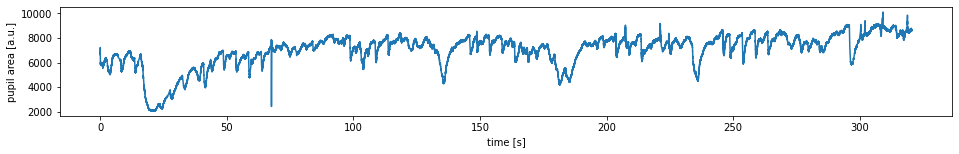

In [31]:
plt.close("all");
plt.clf();
plt.ion();
fig = plt.figure(figsize=(16, 2));
plt.plot(
    t_axis[recording.blink == 0],
    recording.loc[recording.blink == 0, "pupil_size"].values,
);

plt.xlabel("time [s]");
plt.ylabel("pupil area [a.u.]");

In [32]:
events_to_extract = [
    "start mock block",
    "stop mock block",
    "start bh block",
    "stop bh block",
]

timestamps = {event.replace(" ", "_"): None for event in events_to_extract}

for timestamp, event in metadata["LoggedMessages"]:
    if event in events_to_extract:
        timestamps[event.replace(" ", "_")] = int(timestamp)

The breath-holding task included a mock block where participants are instructed to disregard the stimuli and five real blocks, where they were instructed to breathe in, out, and hold their breath as a visual cue is shown.
The cues are just a rectangle with changing colors.

After a breath-hold, the task inserts a 10-second break, with the screen turning entirely black.
The pupil size plot shows an increase during these breaks, notably more pronounced in the second, third, and fourth blocks.
To make this clearer, let's mark the break timings directly on the graph:

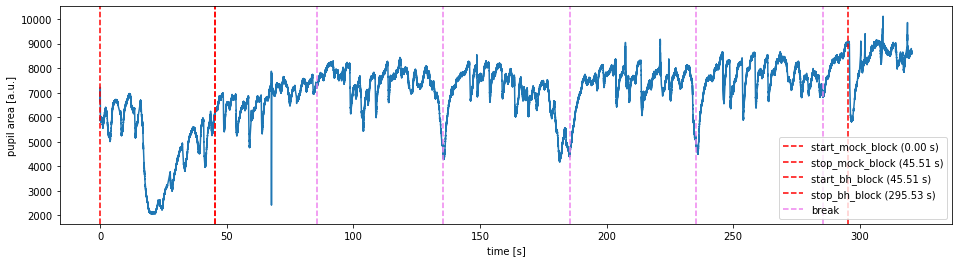

In [33]:
sampling_frequency = metadata["SamplingFrequency"]
timestamps_in_seconds = {
    event: (timestamp - metadata["StartTimestamp"]) / sampling_frequency
    for event, timestamp in timestamps.items()
}

fig = plt.figure(figsize=(16, 4))
plt.plot(
    t_axis[recording.blink == 0],
    recording.loc[recording.blink == 0, "pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")


for event, timestamp in timestamps_in_seconds.items():
    plt.axvline(
        x=timestamp, color="red", linestyle="--", label=f"{event} ({timestamp:.2f} s)"
    )
plt.axvline(
    x=timestamps_in_seconds["start_bh_block"] + 40,
    color="violet",
    linestyle="--",
    label="break",
)
for n in np.arange(1, 5):
    plt.axvline(
        x=timestamps_in_seconds["start_bh_block"] + 40 * (n + 1) + 10 * n,
        color="violet",
        linestyle="--",
    )

plt.legend();


Another interesting observation is a sudden dip in pupil size around 67 seconds from the beginning. This dip coincides with a point where the eye tracking failed, causing a divergence in the y-coordinate. Let's explore this further by visualizing the pupil size and y-coordinate simultaneously around this moment.

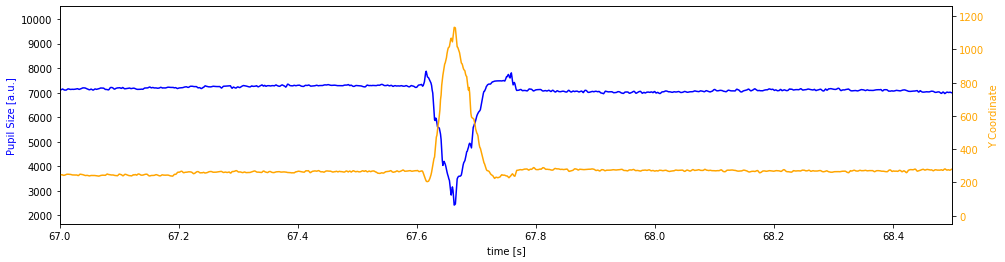

In [34]:
fig, ax1 = plt.subplots(figsize=(16, 4))

ax1.plot(
    t_axis[recording.blink == 0],
    recording.loc[recording.blink == 0, "pupil_size"].values,
    'blue',
    label="Pupil Size"
)
ax1.set_xlabel("time [s]")
ax1.set_ylabel("Pupil Size [a.u.]", color='blue')


ax2 = ax1.twinx()
ax2.plot(
    t_axis,
    recording["y_coordinate"].values,
    'orange', 
    label="Y gaze coordinate"
)
ax2.set_ylabel("Y Coordinate", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


plt.xlim(67, 68.5);

Now, mirroring our approach for the previous tasks, let's closely examine the eyeblink duration throughout this session to ensure the participant stayed alert.

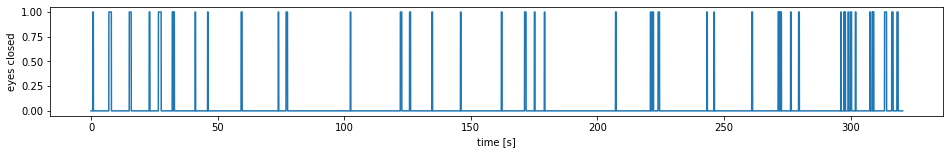

In [35]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)


plt.xlabel("time [s]")
plt.ylabel("eyes closed");

Finally, let's check out the gaze coordinates density map during the task. Since the rectangles were centered on the screen, we expect the gaze to be mostly concentrated here.

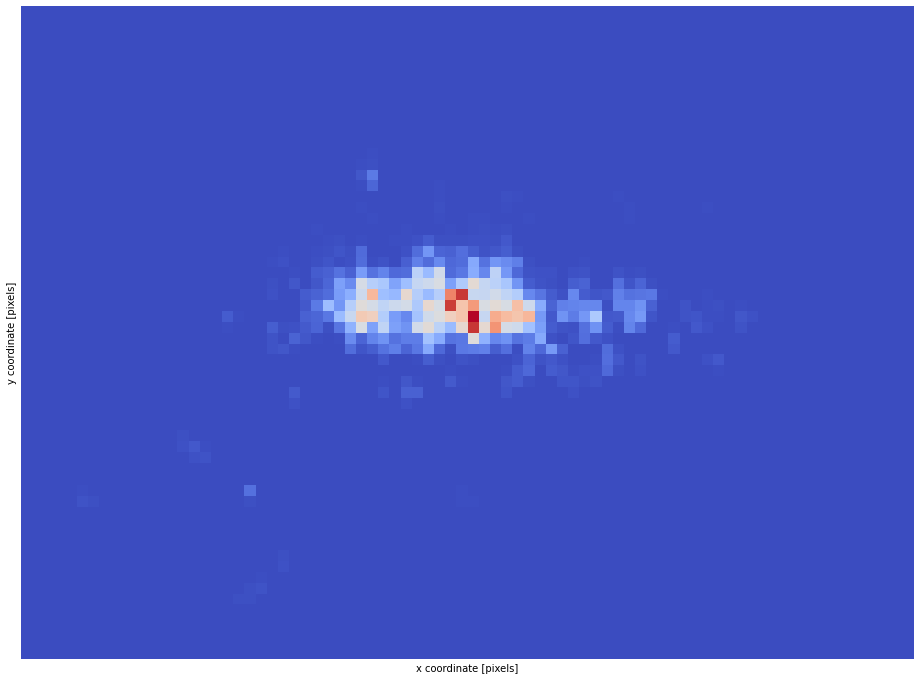

In [36]:
plot.plot_heatmap_coordinate(
    recording[["x_coordinate", "y_coordinate"]],
    density=False,
    screen_size=size,
);